In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [33]:
df = pd.read_csv("C:\\PythonProject\\Housing.csv")
print(df.info())

df_encoded = pd.get_dummies(df, drop_first=True)

X = df_encoded.drop(columns=['price'])
y = df_encoded['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))
y_val_scaled = y_scaler.transform(y_val.values.reshape(-1, 1))

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB
None


In [34]:
class HousePriceModel(nn.Module):
    def __init__(self, features_dim, dropout_rate=0.3):
        super(HousePriceModel, self).__init__()
        self.price_net = nn.Sequential(
            nn.Linear(features_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )


    def forward(self, x):
        return self.price_net(x)

lr_init = 0.001
total_cycles = 250
dropout_rate = 0.3

features_dim = X_train.shape[1]
price_net = HousePriceModel(features_dim)

Early stopping at epoch 33


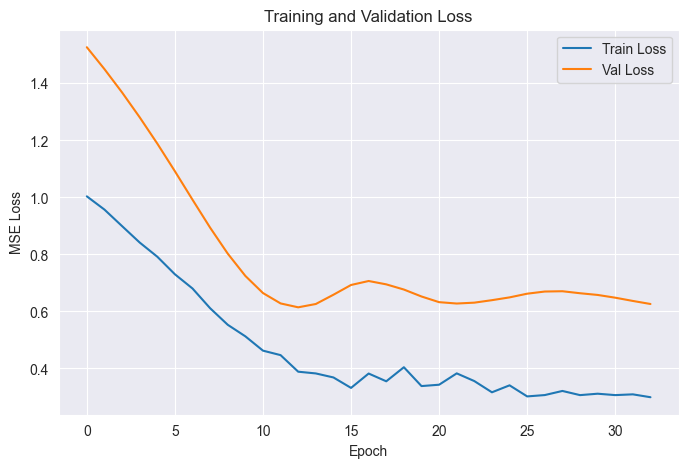

In [35]:
loss_fn = nn.MSELoss()
optimizer_net = optim.Adam(price_net.parameters(), lr=0.001, weight_decay=1e-5)

total_cycles = 250
train_losses = []
val_losses = []

patience = 20
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(total_cycles):
    price_net.train()
    optimizer_net.zero_grad()
    output = price_net(X_train_tensor)
    loss = loss_fn(output, y_train_tensor)
    loss.backward()
    optimizer_net.step()
    train_losses.append(loss.item())

    price_net.eval()
    with torch.no_grad():
        val_output = price_net(X_val_tensor)
        val_loss = loss_fn(val_output, y_val_tensor)
        val_losses.append(val_loss.item())

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

    if (epoch+1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{total_cycles}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()




Train RMSE: 908792.86, R²: 0.7321
Test  RMSE: 1267001.44, R²: 0.7045, MAE: 1007627.94


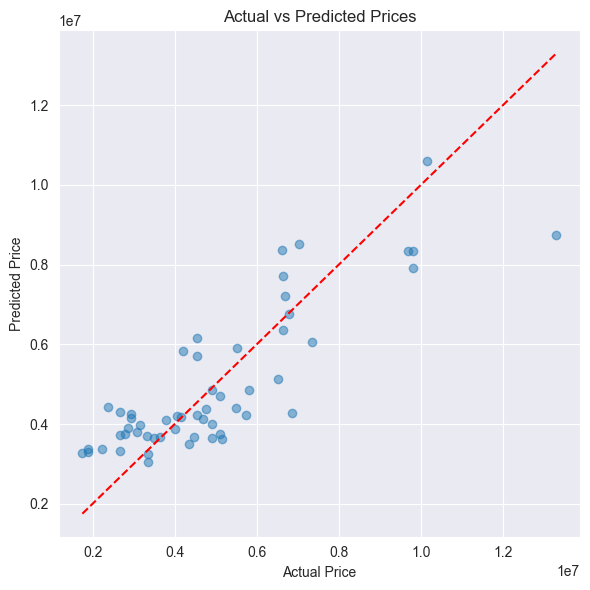


Best Hyperparameters:
Learning Rate: 0.001
Number of Epochs: 250
Dropout Rate: 0.3


In [36]:
price_net.eval()
with torch.no_grad():
    y_pred_train = price_net(X_train_tensor).numpy()
    y_pred_val = price_net(X_val_tensor).numpy()
    y_pred_test = price_net(X_test_tensor).numpy()

    y_pred_train_actual = y_scaler.inverse_transform(y_pred_train)
    y_pred_test_actual = y_scaler.inverse_transform(y_pred_test)
    y_train_actual = y_scaler.inverse_transform(y_train_tensor.numpy())
    y_test_actual = y_scaler.inverse_transform(y_test_tensor.numpy())

    train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_pred_train_actual))
    test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_test_actual))
    train_r2 = r2_score(y_train_actual, y_pred_train_actual)
    test_r2 = r2_score(y_test_actual, y_pred_test_actual)
    test_mae = mean_absolute_error(y_test_actual, y_pred_test_actual)

    print(f"Train RMSE: {train_rmse:.2f}, R²: {train_r2:.4f}")
    print(f"Test  RMSE: {test_rmse:.2f}, R²: {test_r2:.4f}, MAE: {test_mae:.2f}")

plt.figure(figsize=(6,6))
plt.scatter(y_test_actual, y_pred_test_actual, alpha=0.5)
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], color='red', linestyle='--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices")
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nBest Hyperparameters:")
print(f"Learning Rate: {lr_init}")
print(f"Number of Epochs: {total_cycles}")
print(f"Dropout Rate: {dropout_rate}")

In [37]:
torch.save(price_net.state_dict(), "house_price_model.pth")

loaded_model = HousePriceModel(features_dim)
loaded_model.load_state_dict(torch.load("house_price_model.pth"))
loaded_model.eval()

HousePriceModel(
  (model): Sequential(
    (0): Linear(in_features=13, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)